# 巡回セールスマン問題

In [41]:
from utils.setting import get_amplify_token
dotenv_path = "../.env"
amplify_token = get_amplify_token(dotenv_path)

In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def gen_random_tsp(ncity: int):
    locations = np.random.uniform(size=(ncity, 2))

    # 距離行列
    all_diffs = np.expand_dims(locations, axis=1) - np.expand_dims(locations, axis=0)
    distances = np.sqrt(np.sum(all_diffs ** 2, axis=-1))

    return locations, distances

In [44]:
print(locations.shape)
print(np.expand_dims(locations, axis=1).shape)
print(np.expand_dims(locations, axis=0).shape)
print((np.expand_dims(locations, axis=1) - np.expand_dims(locations, axis=0)).shape)

(32, 2)
(32, 1, 2)
(1, 32, 2)
(32, 32, 2)


In [45]:
def show_plot(locs: np.ndarray):
    plt.figure(figsize=(7, 7))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(*zip(*locations))
    plt.show()

In [46]:
ncity = 32
locations, distances = gen_random_tsp(ncity)
print(distances.shape)

(32, 32)


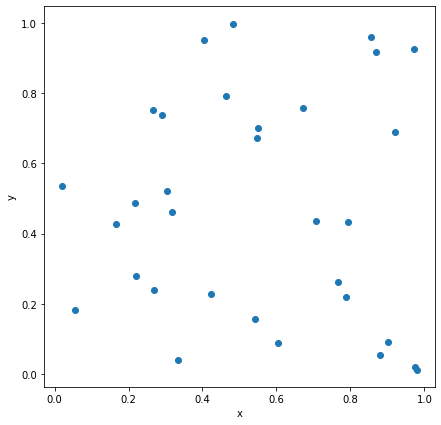

In [47]:
show_plot(locations)

In [48]:
from amplify import (
    BinaryPoly,
    BinaryQuadraticModel,
    sum_poly,
    gen_symbols,
    Solver,
    decode_solution,
)

q = gen_symbols(BinaryPoly, ncity, ncity)


In [49]:
print(len(q), len(q[0]))

32 32


In [50]:
cost = sum_poly(
    ncity,
    lambda n: sum_poly(
        ncity,
        lambda i: sum_poly(
            ncity, lambda j: distances[i][j] * q[n][i] * q[(n + 1) % ncity][j]
        )
    )
)

In [51]:
from amplify.constraint import equal_to

In [52]:
# 行に対する制約
# 行に対する制約
row_constraints = [
    equal_to(sum_poly([q[n][i] for i in range(ncity)]), 1) for n in range(ncity)
]

# 列に対する制約
col_constraints = [
    equal_to(sum_poly([q[n][i] for n in range(ncity)]), 1) for i in range(ncity)
]

constraints = sum(row_constraints) + sum(col_constraints)

In [53]:
constraints *= np.amax(distances)   # 制約条件の強さを設定
model = cost + constraints

In [54]:
print(np.amax(distances))

1.1808687937946347


# イジングマシンの実行

In [55]:
from amplify import Solver
from amplify.client import FixstarsClient

client = FixstarsClient()
client.token = amplify_token
client.parameters.timeout = 5000  # タイムアウト5秒

solver = Solver(client)

In [56]:
result = solver.solve(model)
if len(result) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

energy, values = result[0].energy, result[0].values

In [57]:
from amplify import decode_solution

q_values = decode_solution(q, values, 1)
route = np.where(np.array(q_values) == 1)[1]
print(oute)

[11  6 23  9 21 14 19 24  3  8  2 27 17 29 26 18  5 22  0 10 16  7 12 28
 13 20  4 30 15 31  1 25]


In [58]:
def show_route(route: list, distances: np.ndarray, locations: np.ndarray):

    ncity = len(route)
    path_length = sum(
        [distances[route[i]][route[(i + 1) % ncity]] for i in range(ncity)]
    )

    x = [i[0] for i in locations]
    y = [i[1] for i in locations]
    plt.figure(figsize=(7, 7))
    plt.title(f"path length: {path_length}")
    plt.xlabel("x")
    plt.ylabel("y")

    for i in range(ncity):
        r = route[i]
        n = route[(i + 1) % ncity]
        plt.plot([x[r], x[n]], [y[r], y[n]], "b-")
    plt.plot(x, y, "ro")
    plt.show()

    return path_length

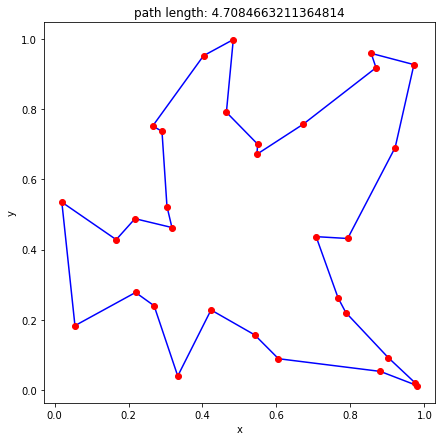

4.7084663211364814

In [59]:
show_route(route, distances, locations)